# NAML Project 4

Credit Card Fraud Detection 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import jax.numpy as jnp
import jax

from tqdm.notebook import tqdm
from math import sqrt
from random import seed
from random import randrange
from math import pi
from math import exp

Load the data

In [10]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project-credit card fraud detection/creditcard.csv')

## Data Inspection

Check if there are some missing entries

In [4]:
dataset.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64

Remove records with missing entries 

In [11]:
dataset = dataset.dropna()
dataset.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Visualize the first rows of the dataset

In [6]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


Visualize information about the dataset including the index dtype and columns, non-null values and memory usage.

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263382 entries, 0 to 263381
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    263382 non-null  float64
 1   V1      263382 non-null  float64
 2   V2      263382 non-null  float64
 3   V3      263382 non-null  float64
 4   V4      263382 non-null  float64
 5   V5      263382 non-null  float64
 6   V6      263382 non-null  float64
 7   V7      263382 non-null  float64
 8   V8      263382 non-null  float64
 9   V9      263382 non-null  float64
 10  V10     263382 non-null  float64
 11  V11     263382 non-null  float64
 12  V12     263382 non-null  float64
 13  V13     263382 non-null  float64
 14  V14     263382 non-null  float64
 15  V15     263382 non-null  float64
 16  V16     263382 non-null  float64
 17  V17     263382 non-null  float64
 18  V18     263382 non-null  float64
 19  V19     263382 non-null  float64
 20  V20     263382 non-null  float64
 21  V21     26

Visualize first order statistics of the dataset including those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

In [8]:
dataset.describe()

KeyboardInterrupt: ignored

Print distribution and approximation of data related to the seconds elapsed between each transaction and the first transaction

In [ ]:
sns.distplot(dataset['Time'])

Visualize pairwise correlation of columns


In [ ]:
dataset.corr()

Display correlations 

In [ ]:
fig, ax = plt.subplots(figsize=(40,40))   
sns.heatmap(dataset.corr(),ax = ax,  annot = True, cmap = 'vlag_r', vmin = -1, vmax = 1)

Show the values assigned to each attribute for those transactions that are classified as fraudulent (`red`) compared to those that are not fraudolent (`green`).

The plots are zoomed-in versions of the real plots to better display the red values

In [ ]:
# split the dataset in fraud and no-fraud subsets

#shuffle rows of the dataset
# frac = 1 determines what fraction of total instances need to be returned
dataset_shuffled = dataset.sample(frac = 1) 

fraud = dataset_shuffled[dataset_shuffled["Class"] == 1]
no_fraud = dataset_shuffled[dataset_shuffled["Class"] == 0]

# create the subplot schema
fig, ax = plt.subplots(10, 3, sharex=False, sharey=False, figsize=(20,70))

n = 30 # number of columns to be printed   
colors = ['red', 'green']

axis = ax.flatten()

for i,j in zip(range(n), axis):
    j.hist([fraud.iloc[:,i], no_fraud.iloc[:,i]], color=colors)
    j.set_title(fraud.columns[i])
    j.set_ylim(top = 5000) # fix y top limit to 5000

## Data Normalization

The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.

We apply this technique to all the columns of the dataset except for `Class`

In [12]:
# remove 'Class' column
dataset_to_be_normalized = dataset.iloc[:,:-1]

# compute the mean 
data_mean = dataset_to_be_normalized.mean()
# compute the standard deviation
data_std = dataset_to_be_normalized.std()
# normalize the data
data_normalized = (dataset_to_be_normalized - data_mean) / data_std

# append 'Class' column
data_normalized['Class'] = dataset.iloc[:,-1]

Display the distribution of the new values

In [ ]:
_, ax = plt.subplots(figsize=(20,10))
sns.violinplot(data = data_normalized, ax = ax)

## Dataset division - Train-validation split

Shuffle the data using the np.random.shuffle function and split the data as follows:

- put 70% in the training dataset
- put 30% in the validation dataset

In [13]:
# define parameter : test_set / training_set
fraction_validation = 0.3 # 30% of test set and 70% of training set

# parse to numpy
data_normalized_np = data_normalized.to_numpy()

# shuffle data
np.random.seed(0) # set seed to 0 for reproducibility
np.random.shuffle(data_normalized_np) 

# divide into training_set and test_set
num_train = int(data_normalized_np.shape[0] * (1 - fraction_validation))

train_set = data_normalized_np[:num_train,:]
valid_set = data_normalized_np[num_train:,:]

print('train set size     : %d' % train_set.shape[0])
print('validation set size: %d' % valid_set.shape[0])

train set size     : 199364
validation set size: 85443


Visualize the dimensions of the sets 

In [ ]:
print('Dataset: ')
print('Number of fraud transactions     : %d' % sum(dataset["Class"]))
print('Number of non-fraud transactions : %d' % sum(dataset["Class"] == 0))
print('Number of transactions           : %d' % dataset["Class"].shape[0])

print('\nTraining set: ')
print('Number of fraud transactions     : %d' % np.sum(train_set[:,data_normalized_np.shape[1]-1]))
print('Number of non-fraud transactions : %d' % np.sum(train_set[:,data_normalized_np.shape[1]-1]  == 0))
print('Number of transactions           : %d' % train_set.shape[0])

print('\nValidation set: ')
print('Number of fraud transactions     : %d' % np.sum(valid_set[:,data_normalized_np.shape[1]-1]))
print('Number of non-fraud transactions : %d' % np.sum(valid_set[:,data_normalized_np.shape[1]-1] == 0))
print('Number of transactions           : %d' % valid_set.shape[0])

## Preprocess data - Random under sampling

The two main approaches to randomly resampling an imbalanced dataset are to delete examples from the majority class, called undersampling, and to duplicate examples from the minority class, called oversampling.


*   Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.
*   Random undersampling deletes examples from the majority class and can result in losing information invaluable to a model.

Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset. Random undersampling involves randomly selecting examples from the majority class and deleting them from the training dataset.

*This method is valid under the hypothesis that the number of the no-fraud transaction is more than a hundred times the number of fraud ones*


In [14]:
def RUS(ratio, training_set):
  '''It returns a list obtained by merging two lists, one containing the fraud training set and the
  other containing the non-fraud training set.
  The ratio parameter defines the ratio fraud/non-fraud.
  e.g.: ratio=1 and len(train_fraud)= 100 implies that len(new_train_not_fraud)=100.
  
  @param: ratio It is the ratio between fraud and non-fraud data; it is defined as: ratio:=fraud_set/non-fraud_set.
  @param training_set It is the training set.
  '''
  # initialize the two lists
  train_fraud = list()
  train_not_fraud = list()

  # for each sample in the training set, append it to the proper class
  for sample in training_set:
    if sample[-1] == 1:
      train_fraud.append(sample)
    else:
      train_not_fraud.append(sample)
  
  print('train_fraud len        : ', len(train_fraud))
  print('train_not_fraud len    : ', len(train_not_fraud))
  
  # compute new length of train_not_fraud
  new_length_train_not_fraud = int(len(train_fraud) / ratio)
  print('new train_not_fraud len: ', new_length_train_not_fraud)

  # shuffle train_not_fraud
  np.random.seed(0) # set seed to 0 for reproducibility
  np.random.shuffle(train_not_fraud)

  # take the first new_length_train_not_fraud elements from train_not_fraud
  train_not_fraud_reduced = train_not_fraud[0:new_length_train_not_fraud]

  # create a unique list for the training set
  train_fraud.extend(train_not_fraud_reduced)

  # shuffle the result set
  np.random.seed(0) # set seed to 0 for reproducibility
  np.random.shuffle(train_fraud)

  print('new training set len   : ', len(train_fraud))
  print('\n')

  # return the whole new training set
  return train_fraud

In [15]:
# define parameters -> inside the training_set: fraud / non-fraud
ratio1 = 1 # 50:50
ratio2 = 34/66 # 34:66
ratio3 = 1/3 # 25:75

Apply random under sampling to the training set

In [16]:
training_set1 = RUS(ratio1, train_set)
training_set2 = RUS(ratio2, train_set)
training_set3 = RUS(ratio3, train_set)

train_fraud len        :  337
train_not_fraud len    :  199027
new train_not_fraud len:  337
new training set len   :  674


train_fraud len        :  337
train_not_fraud len    :  199027
new train_not_fraud len:  654
new training set len   :  991


train_fraud len        :  337
train_not_fraud len    :  199027
new train_not_fraud len:  1011
new training set len   :  1348




## **Classification techniques** - Logistic Regression



Logistic regression is one of the most popular Machine Learning algorithms, which comes under the Supervised Learning technique. It is used for predicting the categorical dependent variable using a given set of independent variables.

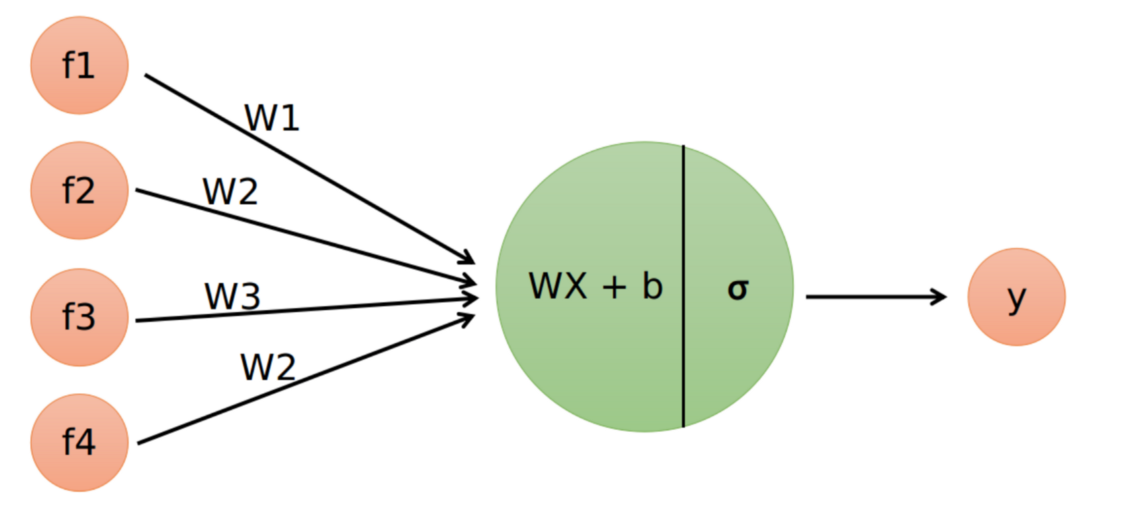

Firstly we define some useful functions

**Sigmoid function**, also called logistic sigmoid function, has the role of activation function.  It is define as 



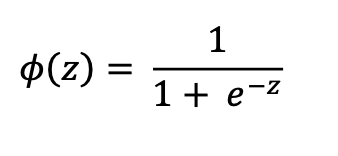

where z is 

> *z = w * x + b*

and

> *w = weights*

> *x = features*

> *b = bias*


In [ ]:
def sigmoid(z):
  """
  This function returns the value of the sigmoid function given an input value

  @params: z: a linear combination of the input and the features associated with the training examples
  """
  return (1/(1+jnp.exp(-z)))

In [ ]:
# print the sigmoid function in the range (-7 , +7)

# define range
z = np.arange(-7, 7, 0.1) 

# calculate the sigmoid
phi_z = sigmoid(z) 
plt.plot(z, phi_z)

plt.axvline(0.0, color='k') 
plt.ylim(-0.1, 1.1)

# add labels 
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# add y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca() # get current axis
ax.yaxis.grid(True) # display axis 
plt.tight_layout() # adjust the padding between and around subplots

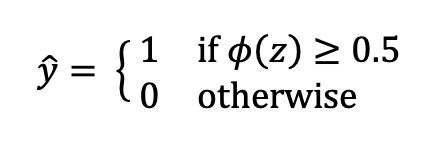

The output of the sigmoid function is interpreted as the probability of
a particular example belonging to class 1.

**Loss** can be defined as the error that is present between the actual output and the predicted output. We want the value of the loss function to be as low as possible as it would reduce the loss and the predicted value would be close to the actual value. We will use the following loss function

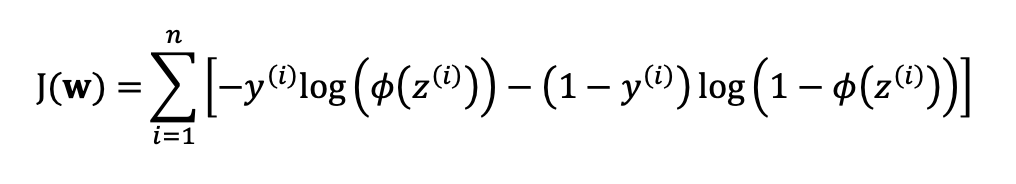

where `log` refers to the natural log

In [ ]:
def loss(x,y,params):
  """
  This function estimates the cost we want to minimize. The cost is the discrepancy between the real output and the predicted one

  @params: x: feature's list
  @params: y: real output
  @params: params: weights and bias
  """
  # initialize the cost 
  cost = 0.
  weights = params[:-1]
  bias = params[-1]

  # for each sample calculate the predicted value and so the loss
  for i in range(len(x)):
    # calculate the sigmoid
    yHat = sigmoid(jnp.dot(weights,x[i]) + bias)
    not_yHat = 1-yHat
    # to prevent the computation of log(0) = inf, the argument of the logarithm will be pre-defined
    value = y[i]*yHat + (1-y[i])*not_yHat
    cost += (-jnp.log(value))

  return (cost)

The following plot shows the sigmoid activation on the x-axis in the range 0 to 1 (the inputs to the sigmoid function were z values in the range –10 to 10) and the associated logistic cost on the y-axis

In [ ]:
# print log function 
def cost_1(z):
  return - np.log(sigmoid(z))

def cost_0(z):
  return - np.log(1 - sigmoid(z))

# define the range
z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

# impose the limits 
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])

# add the axis legend
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')

# add legend
plt.legend(loc='best') 
plt.tight_layout() 

At the beginning, all the weights and the bias are initialized to 0

In [ ]:
def initialize_params(weight_size):
  """
  The purpose of this function is to initialize the weights and bias

  @params: weight_size: number of features 
  @return: array of dimention (weights_size + 1) initialize to zero 
  """
  return np.zeros(weight_size + 1) 

Algorithm: 

1. divide the training set into features and expected results 
2. initialize the hyperparameters
3. according to the gradient descent rule, update parameters

In [ ]:
def training_gradient_descent(training_set):
  """
  This function trains the model  

  @params: training_set: bunches of samples 
  @return: update parameters
  """

  # initialize the lists
  x_train = list()
  y_train = list()

  # split the set into features and results
  for sample in training_set:
    x_train.append(sample[:-1])
    y_train.append(sample[-1])

  # inizialize hyperparameters
  num_epochs = 1000
  learning_rate = 1e-1
  params = initialize_params(len(x_train[0]))

  # use `jax.jit` to speedup the evaluation of the loss and of the gradients
  grad_jit = jax.jit(jax.grad(loss, argnums=2))
  loss_jit = jax.jit(loss)

  # save the history of the loss function in order to print it at the end of the 
  # training process
  train_history = [loss_jit(x_train, y_train, params)]

  # show the progress bar:
  t0 = time.time()
  # training loop
  for epoch in tqdm(range(num_epochs)):
    # caluclate the gradient 
    gradients = grad_jit(x_train, y_train, params)
    for i in range(len(params)):
      # update the parameters
      params[i] -= learning_rate * gradients[i]
    train_history.append(loss_jit(x_train, y_train, params))
  
  print('train loss       : %1.3e' % train_history[-1])
  plt.loglog(train_history, label = 'train loss')

  return params.copy()

In [ ]:
def training_stochastic_gradient_descent(training_set):
  """
  This function trains the model  

  @params: training_set: bunches of samples 
  @return: update parameters
  """

  # initialize the lists
  x_train = list()
  y_train = list()

  # split the set into features and results
  for sample in training_set:
    x_train.append(sample[:-1])
    y_train.append(sample[-1])

  # inizialize hyperparameters
  num_epochs = 1000
  learning_rate = 1e-1
  params = initialize_params(len(x_train[0]))  
  batch_size = 100
  num_train = len(training_set)-1

  # use `jax.jit` to speedup the evaluation of the loss and of the gradients
  grad_jit = jax.jit(jax.grad(loss, argnums=2))
  loss_jit = jax.jit(loss)

  # save the history of the loss function in order to print it at the end of the 
  # training process
  train_history = [loss_jit(x_train, y_train, params)]

  # training loop
  t0 = time.time()
  for epoch in tqdm(range(num_epochs)):
    minibatch = np.random.choice(num_train, batch_size)
    x = list()
    y = list()
    for i in minibatch:
      x.append(x_train[i])
      y.append(y_train[i])
    gradients = grad_jit(x, y, params)
    for i in range(len(params)):
      params[i] -= learning_rate * gradients[i]

    train_history.append(loss_jit(x_train, y_train, params))

  print('train loss: %1.3e' % train_history[-1])
  plt.loglog(train_history, label = 'train loss')

  return params.copy()

Train and Test

Collect all the yHat in a list

In [ ]:
def predicted_results(x,params):
  """
  This function assigns to each sample the predicted output

  @params: x: samples
  @params: params: weights and bias
  @return: list of predicted output
  """
  # initialize an empty list
  prediction = list()

  # for each sample compute the sigmoid function 
  for i in range(len(x)):
    weights = params[:-1]
    bias = params[-1]
    # cast the result to 1 if sigmoid >= 0.5 
    if(sigmoid(jnp.dot(weights,x[i])+ bias)) >= 0.5:
      prediction.append(1.)
    else:
      prediction.append(0.)
  return prediction

In [ ]:
def logistic_regression(training_set, test_set):
  x_valid = list()
  y_valid = list()

  for sample in test_set:
    x_valid.append(sample[:-1])
    y_valid.append(sample[-1])

  # train the model
  params = training_stochastic_gradient_descent(training_set)

  # test the model 
  print('validation loss 1: %1.3e \n' % loss(x_valid,y_valid,params))

  return predicted_results(x_valid,params)

### Apply the algorithm 

In [ ]:
predictionsLR1 = logistic_regression(training_set1,valid_set)

In [ ]:
predictionsLR2 = logistic_regression(training_set2,valid_set)

In [ ]:
predictionsLR3 = logistic_regression(training_set3,valid_set)

## **Classification techniques** - K-Nearest Neighbours

Three main steps:
1. calculate Euclidean distance;
2. get nearest neighbours;
3. make predictions.

### Define the distance

There are various kinds of distances, for instance Euclidean distance, Hamming distance, Manhattan distance and Minkowski distance. For the euclidean distance, I simply compute the L2 norm of two vectors (the rows of the dataset):

In [17]:
def euclidean_distance(row1, row2):
  ''' It computes the Euclidean distance between vectors row1 and row2.

  @param: row1 First vector.
  @param: row2 Second vector.  
  '''
  
  distance = 0.0
  for i in range(len(row1)-1): # go up to len(row)-1 because the last element of the row is the output
    distance += (row1[i] - row2[i])**2
  return sqrt(distance)

### Get nearest neighbours

The steps are:
1.   take a sample;
2.   compute the distance between such sample and every other sample in the dataset;
3. sort the samples (in descending order) according to the computed distances;
4. select the best k samples (the nearest neighbours).



In [18]:
def get_neighbors(train_set, sample, k):
  """ It returns a list containing the k nearest neighbours of sample in train.

  @param: train_set The training set from which extracting the neighbours.
  @param: sample The sample to consider; we want its neighbours.
  @param: k The number of nearest neighbours to extract.
  """

  distances = list() # here I store all the distances

  # compute the distances
  for train_row in train_set:
    dist = euclidean_distance(sample, train_row)
    distances.append((train_row, dist)) # in distances I append pairs of values row-distance

  # sort the samples:
  # key is a lambda which is executed prior to make comparisons; so we are sorting
  # the samples by the second (0-indexed) elements of objects in distances (namely, the distances)
  distances.sort(key=lambda tup: tup[1]) 

  # get the neighbours
  neighbors = list()
  for i in range(k):
    neighbors.append(distances[i][0]) # append only the sample (not the distance)

  return neighbors

### Make predictions

It is a classification task: we just have to compute the most frequent class in the neighborood to carry out the prediction:

In [19]:
def predict_classification(training_set, sample, k):
  '''It provides a prediction for sample using the training_set and the best k neighbours.

  @param: training_set It is the training set to use for providing a prediction for sample.
  @param: sample The sample for which providing the prediction.
  @param: k The hyperparameter of the algorithm; it represents the number of nearest neighbours to use.
  '''

  # get the k-nearest neighbours
  neighbors = get_neighbors(training_set, sample, k)

  # get the classes of the k-nearest neighbours
  output_values = [row[-1] for row in neighbors] # I take row[-1] because the class is the last entry of the row

  # perform the prediction: I take the most frequent class (output value)
  prediction = max(set(output_values), key=output_values.count)
  
  return prediction

### Algorithm

In [20]:
# KNN Algorithm
def k_nearest_neighbors(training_set, test_set, k):
	"""
	It applies the KNN algorithm to each entry of the test_set using the training_set as training set
	and using k as hyperparameter.

	@param: training_set It is the training set to use.
	@param: test_set It is the test set; this function provides a prediction for each entry of the test_set.
	@param: k It represents the main hyperparameter of the algorithm, namely it says how many nearest neighbours
	to use for computing the prediction.
	"""

	# we return a list of predictions
	predictions = list()
 
	# compute a prediction for each entry of the test_set
	for row in test_set:
		output = predict_classification(training_set, row, k)
		predictions.append(output)
	
	return(predictions)

### Apply the algorithm

In [21]:
# hyperparameter k
k = 10

# apply random under sampling to the test set
test_set1 = RUS(ratio1, valid_set)
test_set2 = RUS(ratio2, valid_set)
test_set3 = RUS(ratio3, valid_set)

train_fraud len        :  155
train_not_fraud len    :  85288
new train_not_fraud len:  155
new training set len   :  310


train_fraud len        :  155
train_not_fraud len    :  85288
new train_not_fraud len:  300
new training set len   :  455


train_fraud len        :  155
train_not_fraud len    :  85288
new train_not_fraud len:  465
new training set len   :  620




In [22]:
# proportion 1: 50:50
predictionsKNN1 = k_nearest_neighbors(training_set1, test_set1, k)

In [23]:
# proportion 2: 34:66
predictionsKNN2 = k_nearest_neighbors(training_set2, test_set2, k)

In [24]:
# proportion 3: 25:75
predictionsKNN3 = k_nearest_neighbors(training_set3, test_set3, k)

## **Classification techniques** - Naive Bayes

Five main steps:

1. separate all the rows by class (divide the dataset in more datasets, one for each class);
2. summarize dataset, namely compute mean, variance and cardinality of each column of the dataset;
3. summarize the dataset by class, namely do the same as 2. but for each dataset created at 1.;
4. define the probability density function with which modelling the distribution of each column for each class (strong assumption);
5. compute the class probabilities by applying the Bayes theorem (simplified).




The main goal is to apply the formula:

$p(y_i|x_1,x_2,...,x_n) = p(x_1|y_i)p(x_2|y_i)...p(x_n|y_i)p(y_i)$

which is the Bayes theorem simplified with two assumptions:
1. the variables($x_j$) are independent;
2. since the denominator, under 1., becomes a constant ($p(x_1)p(x_2)...p(x_n)$), we can remove it, since we care only about the maximum value, and not about the probability itself.

### Separate by class

We can create a dictionary object where each key is the class value and each object is a list of all the records with that class value; the structure is:

separated = {class_value1: [entry1, entry2,...], class_value2: [entry1, entry2,...],}

where class_valuei represents the i-th class value, and the list contains all entries of the dataset with that class value.

In [25]:
def separate_by_class(dataset):
  """
  It returns a dictionary whose keys are the class values and whose objects are lists
  of entries of the dataset with the proper class value.
  
  @param: dataset It is a list of lists, where each inner list is a sample.
  """

  separated = dict()

  # for each entry of the dataset, add it to the list associated to its class value
  for i in range(len(dataset)):
    vector = dataset[i]
    class_value = vector[-1] # the class is in the last column

    # if the class value is not present in the dictionary, add it as a key along with a new list
    if (class_value not in separated):
      separated[class_value] = list()

    # add the entry to the dictionary
    separated[class_value].append(vector)

  return separated

### Summarize dataset

In order to compute all the probabilities we need to make a prediction, we need to know mean, standard deviation and cardinality of each column:

In [26]:
# mean
def mean(numbers):
  '''It calculates the mean of a list of numbers.
  
  @param: numbers It is a list of numbers.'''

  return sum(numbers)/float(len(numbers))

In [27]:
# standard deviation
def stdev(numbers):
  '''It calculates the standard deviation of a list of numbers.
  
  @param: numbers It is a list of numbers.'''

  avg = mean(numbers)
  variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
  return sqrt(variance)

In [28]:
# Calculate the mean, stdev and count for each column in a dataset
def summarize_dataset(dataset):
  """
  It returns a list of triples. The returned summaries contains one triple for each
  column of dataset (except for the last column); each triple contains (mean, std, len).
  
  @param: dataset It is a list of lists, where each inner list is a sample of the dataset.
  """
  
  # through the asterisk and the zip function I can create an iterable of lists
  # whose elements are the columns of the dataset
  summaries = [(mean(column), stdev(column), len(column)) for column in zip(*dataset)]

  # summaries is a list; I delete the last element, which are the statistics for the class column
  del(summaries[-1])
  
  return summaries

### Summarize data by class

We require statistics from our training dataset organized by class:

In [29]:
def summarize_by_class(dataset):
  """
  It returns a dictionary where the keys are the class values and the objects are
  lists of triples. So, to each class value (key) we associate a list of triples, where
  each triple contains (mean,std,len) of a column. The cardinality of each list is equal
  to the number of columns (features xi) of the dataset.

  @param: dataset It is a list of lists, where each inner list is a sample.
  """

  # get a dictionary class_value -> entries
  separated = separate_by_class(dataset)

  summaries = dict()

  # for each list of entries of a class value, compute the statistics and store them into summaries
  for class_value, rows in separated.items():
    summaries[class_value] = summarize_dataset(rows)
    
  return summaries

### Probability Density Function

Since calculating the probability of observing a certain real-value given the label is difficult, we assume that the distribution is known.

In [30]:
def calculate_probability(x, mean, stdev):
  """
  It computes the Gaussian probability distribution function for a value x
  given the mean and the standard deviation.

  @param: mean It is the mean of the distribution.
  @param: stdev It is the standard deviation of the distribution.
  """
  
  exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
  return (1 / (sqrt(2 * pi) * stdev)) * exponent

### Class Probabilities

Given a certain sample for which we want to compute the most likely label, we compute the value of:

$p(y_i|x_1,x_2,...,x_n) = p(x_1|y_i)p(x_2|y_i)...p(x_n|y_i)p(y_i)$

for each of the possible class values.

In [31]:
def calculate_class_probabilities(summaries, sample):
  """
  It computes a dictionary whose keys are the class values yi and whose objects are
  the values of p(yi|x1,x2,...xn). To do so, it applies the Bayes formula under
  the independency assumption of the features.

  @param: summaries It is a dictionary whose keys are the class values and whose objects
          are lists of triples, where each triple represents the statistics of a column.
  @param: sample It is one sample, one row of the original dataset on which we want to
          make a prediction.
  """

  # compute the total number of rows in the dataset
  total_rows = sum([summaries[class_value][0][2] for class_value in summaries])

  probabilities = dict()

  # for each class value yi, compute the value of p(yi|x1,x2,...xn) and add it to probabilities.
  for class_value, class_summaries in summaries.items():
    
    # p(yi) = n_samples_of_the_class / total_n_of_samples
    probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)

    # for each of the columns (feature xi) of the dataset (the last was previously removed)
    for i in range(len(class_summaries)):
      mean, stdev, count = class_summaries[i]

      # the probability p(yi|x1,x2,...,xn)=p(yi)*p(x1|yi)*p(x2|yi)*...*p(xn|yi)
      probabilities[class_value] *= calculate_probability(sample[i], mean, stdev)
   
  # we return a dictionary that contains, for each class value, the probability:
  # class_value yi -> p(yi|x1,x2,...xn)
  return probabilities

### Make predictions

Select the class with highest probability to make a prediction:

In [32]:
# Predict the class for a given sample
def predict(summaries, sample):
	# compute the possibility yi -> p(yi|x1,x2,...xn) for each class yi
	probabilities = calculate_class_probabilities(summaries, sample)
	best_label, best_prob = None, -1

  # extract the class with maximum value
	for class_value, probability in probabilities.items():
		if best_label is None or probability > best_prob:
			best_prob = probability
			best_label = class_value
			
	return best_label

### Algorithm

Compute a prediction for each sample in the test set; the training set is used only at the beginning to learn the distributions of all the $p(y_i)$ and $p(x_j|y_i)$.

In [33]:
# Naive Bayes Algorithm
def naive_bayes(training_set, test_set):

  # I compute all the statistics needed on the training_set
  summarize = summarize_by_class(training_set)

  predictions = list()

  # for each row in the test_set I compute the prediction and I append it in predictions list
  for row in test_set:
    output = predict(summarize, row)
    predictions.append(output)

  # return a list with all the predictions
  return(predictions)

### Apply the algorithm

In [34]:
# proportion 1: 50:50
predictionsNB1 = naive_bayes(training_set1, valid_set)

In [35]:
# proportion 2: 34:66
predictionsNB2 = naive_bayes(training_set2, valid_set)

In [36]:
# proportion 3: 25:75
predictionsNB3 = naive_bayes(training_set3, valid_set)

## Performance evaluation

Calculete the parametes 

In [37]:
def collect_rates(y_valid,prediction1,prediction2,prediction3):
  """
  This function returs the number of TP,TN,FP,FN

  @params: y_valid: expected output
  @params: prediction1: output predicted by the model trained with the ratio 50:50
  @params: prediction2: output predicted by the model trained with the ratio 34:64
  @params: prediction3: output predicted by the model trained with the ratio 25:75
  @return: list[TP,TN,FP,FN]
  """

  truePositive = [0,0,0]
  trueNegative = [0,0,0]
  falsePositive = [0,0,0]
  falseNegative = [0,0,0]

  for i in range(len(y_valid)):

    if (y_valid[i] == 1) and (prediction1[i]== 1 ):
      truePositive[0] += 1
    if (y_valid[i] == 0) and (prediction1[i] == 0):
      trueNegative[0] += 1
    if (y_valid[i] == 0) and (prediction1[i]== 1 ):
      falsePositive[0] += 1
    if (y_valid[i] == 1) and (prediction1[i] == 0):
      falseNegative[0] += 1

    if (y_valid[i] == 1) and (prediction2[i]== 1 ):
      truePositive[1] += 1
    if (y_valid[i] == 0) and (prediction2[i] == 0):
      trueNegative[1] += 1
    if (y_valid[i] == 0) and (prediction2[i]== 1 ):
      falsePositive[1] += 1
    if (y_valid[i] == 1) and (prediction2[i] == 0):
      falseNegative[1] += 1

    if (y_valid[i] == 1) and (prediction3[i]== 1 ):
      truePositive[2] += 1
    if (y_valid[i] == 0) and (prediction3[i] == 0):
      trueNegative[2] += 1
    if (y_valid[i] == 0) and (prediction3[i]== 1 ):
      falsePositive[2] += 1
    if (y_valid[i] == 1) and (prediction3[i] == 0):
      falseNegative[2] += 1
  
  return np.array([truePositive,trueNegative,falsePositive,falseNegative])

In [63]:
def collect_rates_single_prediction(y_valid,prediction):
  """
  This function returs the number of TP,TN,FP,FN

  @params: y_valid: expected output
  @params: prediction1: output predicted by the model trained with the ratio 50:50
  @params: prediction2: output predicted by the model trained with the ratio 34:64
  @params: prediction3: output predicted by the model trained with the ratio 25:75
  @return: list[TP,TN,FP,FN]
  """

  truePositive = 0
  trueNegative = 0
  falsePositive = 0
  falseNegative = 0

  for i in range(len(y_valid)):

    if (y_valid[i] == 1) and (prediction[i]== 1 ):
      truePositive += 1
    if (y_valid[i] == 0) and (prediction[i] == 0):
      trueNegative += 1
    if (y_valid[i] == 0) and (prediction[i]== 1 ):
      falsePositive += 1
    if (y_valid[i] == 1) and (prediction[i] == 0):
      falseNegative += 1
  
  return [truePositive,trueNegative,falsePositive,falseNegative]

In [38]:
def collect_rates_test_subsets(test_set1,test_set2,test_set3,prediction1,prediction2,prediction3):
  """
  This function returs the number of TP,TN,FP,FN

  @params: test_set1: expected output for prefiction1
  @params: test_set2: expected output for prefiction2
  @params: test_set3: expected output for prefiction3
  @params: prediction1: output predicted by the model trained with the ratio 50:50
  @params: prediction2: output predicted by the model trained with the ratio 34:64
  @params: prediction3: output predicted by the model trained with the ratio 25:75
  @return: list[TP,TN,FP,FN]
  """
  #save just the last column

  truePositive = [0,0,0]
  trueNegative = [0,0,0]
  falsePositive = [0,0,0]
  falseNegative = [0,0,0]

  for i in range(len(test_set1)):

    if (test_set1[i][-1] == 1) and (prediction1[i]== 1 ):
      truePositive[0] += 1
    if (test_set1[i][-1] == 0) and (prediction1[i] == 0):
      trueNegative[0] += 1
    if (test_set1[i][-1] == 0) and (prediction1[i]== 1 ):
      falsePositive[0] += 1
    if (test_set1[i][-1] == 1) and (prediction1[i] == 0):
      falseNegative[0] += 1

  for i in range(len(test_set2)):

    if (test_set2[i][-1] == 1) and (prediction2[i]== 1 ):
      truePositive[1] += 1
    if (test_set2[i][-1] == 0) and (prediction2[i] == 0):
      trueNegative[1] += 1
    if (test_set2[i][-1] == 0) and (prediction2[i]== 1 ):
      falsePositive[1] += 1
    if (test_set2[i][-1] == 1) and (prediction2[i] == 0):
      falseNegative[1] += 1

  for i in range(len(test_set3)):
    if (test_set3[i][-1] == 1) and (prediction3[i]== 1 ):
      truePositive[2] += 1
    if (test_set3[i][-1] == 0) and (prediction3[i] == 0):
      trueNegative[2] += 1
    if (test_set3[i][-1] == 0) and (prediction3[i]== 1 ):
      falsePositive[2] += 1
    if (test_set3[i][-1] == 1) and (prediction3[i] == 0):
      falseNegative[2] += 1
  
  return np.array([truePositive,trueNegative,falsePositive,falseNegative])

In [40]:
#performancesLR = collect_rates(y_valid,predictionsLR1,predictionsLR2,predictionsLR3)
performancesKNN = collect_rates_test_subsets(test_set1,test_set2,test_set3,predictionsKNN1,predictionsKNN2,predictionsKNN3)
performancesNB = collect_rates(y_valid,predictionsNB1,predictionsNB2,predictionsNB3)

NameError: ignored

In [ ]:
algorithms = ["Logistic Regression", "K-Nearest Neighbours", "Naive Bayes"]
ratio = ["ratio 50:50", "ratio 34:66", "ratio 25:75"]
values = ["TP", "TN", "FP", "FN"]

print("\033[1m" + algorithms[0] + "\033[0m")
for i in range(len(performancesLR[0])):
  print(ratio[i])
  for j in range(len(performancesLR)):
    print(values[j] + " : %d" % performancesLR[j][i])
  print('\n')

print("\033[1m" + algorithms[1] + "\033[0m")
for i in range(len(performancesKNN[0])):
  print(ratio[i])
  for j in range(len(performancesKNN)):
    print(values[j] + " : %d" % performancesKNN[j][i])
  print('\n')

print("\033[1m" + algorithms[2] + "\033[0m")
for i in range(len(performancesNB[0])):
  print(ratio[i])
  for j in range(len(performancesNB)):
    print(values[j] + " : %d" % performancesNB[j][i])
  print('\n')

###Accuracy 
Defined as the ratio of the total number of predicted transactions that are correct

In [41]:
def accuracy(TP,TN,FP,FN):
  return (TP + TN) / (TP + FP + TN + FN)

### Sensitivity 

The proportion of positive observed values correctly predicted as positive. It is also called as True Positive Rate (TPR) or Recall

In [42]:
def sensitivity(TP,FN):
  return TP/(TP+FN)

### Specificity 
Defined as, with how much accuracy the negative (legitimate) cases are classified and, in our case, it gives the accuracy on prediction of legitimate transactions classification. It is also called as True Negative Rate (TNR)

In [43]:
def specificity(TN,FP):
  return TN/(FP+TN)

### Precision 
The proportion of positive (fraud) predictions that are actually correct 

In [44]:
def precision(TP,FP):
  return TP/(TP+FP)

### F-measure 
It gives the accuracy of the test which means that it gives the accuracy of experiments performed. It uses the both precision and recall to compute its value. The best value for f1 score is considered at value 1

In [45]:
def F_measure(precision,sensitivity):
  return (2 * ((precision * sensitivity)/(precision + sensitivity)))

### Area under curve (AUC) 

It represents degree or measure of separability that is how much model is capable of differentiating between the classes

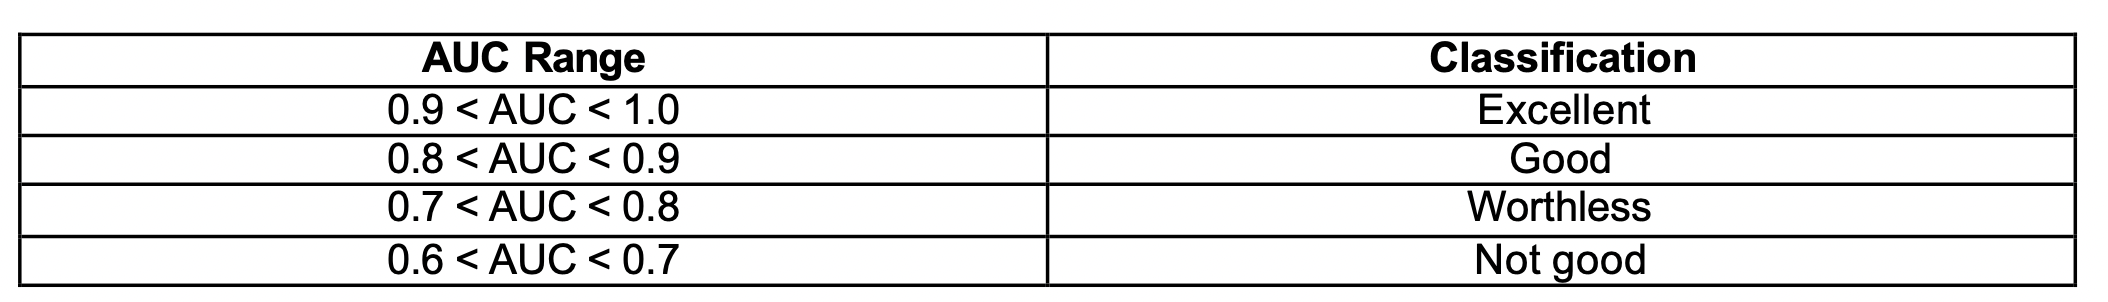

In [46]:
def AUC(sensitivity, specificity):
  return (0.5 * (sensitivity + specificity))

Summary :

In [47]:
logisticRegression = list()
kNearestNeighbours = list()
naiveBayes = list()

print("\033[1m" + algorithms[0] + "\033[0m")
for i in range(3):
  print(ratio[i])
  acc = accuracy(performancesLR[0][i], performancesLR[1][i], performancesLR[2][i], performancesLR[3][i]),
  sens = sensitivity(performancesLR[0][i], performancesLR[3][i]),
  spec = specificity(performancesLR[1][i], performancesLR[2][i]),
  prec = precision(performancesLR[0][i], performancesLR[2][i])
  f_me = F_measure(prec,sens[0])
  auc = AUC(sens[0],spec[0])
  
  print('Accurancy   ' + '{:.1%}'.format(acc[0]))
  print('Sensitivity ' + '{:.1%}'.format(sens[0]))
  print('Specificity ' + '{:.1%}'.format(spec[0]))
  print('Precision   ' + '{:.1%}'.format(prec))
  print('F_measure   ' + '{:.1%}'.format(f_me))
  print('AUC         ' + '{:.1%}'.format(auc) + '\n')

  logisticRegression.append([acc[0], sens[0],spec[0],prec,f_me,auc])

print("\033[1m" + algorithms[1] + "\033[0m")
for i in range(3):
  print(ratio[i])
  acc = accuracy(performancesKNN[0][i], performancesKNN[1][i], performancesKNN[2][i], performancesKNN[3][i]),
  sens = sensitivity(performancesKNN[0][i], performancesKNN[3][i]),
  spec = specificity(performancesKNN[1][i], performancesKNN[2][i]),
  prec = precision(performancesKNN[0][i], performancesKNN[2][i])
  f_me = F_measure(prec,sens[0])
  auc = AUC(sens[0],spec[0])
  
  print('Accurancy   ' + '{:.1%}'.format(acc[0]))
  print('Sensitivity ' + '{:.1%}'.format(sens[0]))
  print('Specificity ' + '{:.1%}'.format(spec[0]))
  print('Precision   ' + '{:.1%}'.format(prec))
  print('F_measure   ' + '{:.1%}'.format(f_me))
  print('AUC         ' + '{:.1%}'.format(auc) + '\n')

  kNearestNeighbours.append([acc[0], sens[0],spec[0],prec,f_me,auc])

print("\033[1m" + algorithms[2] + "\033[0m")
for i in range(3):
  print(ratio[i])
  acc = accuracy(performancesNB[0][i], performancesNB[1][i], performancesNB[2][i], performancesNB[3][i]),
  sens = sensitivity(performancesNB[0][i], performancesNB[3][i]),
  spec = specificity(performancesNB[1][i], performancesNB[2][i]),
  prec = precision(performancesNB[0][i], performancesNB[2][i])
  f_me = F_measure(prec,sens[0])
  auc = AUC(sens[0],spec[0])
  
  print('Accurancy   ' + '{:.1%}'.format(acc[0]))
  print('Sensitivity ' + '{:.1%}'.format(sens[0]))
  print('Specificity ' + '{:.1%}'.format(spec[0]))
  print('Precision   ' + '{:.1%}'.format(prec))
  print('F_measure   ' + '{:.1%}'.format(f_me))
  print('AUC         ' + '{:.1%}'.format(auc) + '\n')

  naiveBayes.append([acc[0], sens[0],spec[0],prec,f_me,auc])


NameError: ignored

The plots below show performance evaluations of the three algorithms separately

Plot the results 



*   RUS 1 -> Random Under Sampling with ratio 50:50
*   RUS 2 -> Random Under Sampling with ratio 34:66
*   RUS 3 -> Random Under Sampling with ratio 25:75




In [ ]:
labels = ['Accurancy', 'Sensitivity', 'Specificity', 'Precision', 'F-Measure', 'AUC']

RUS1 = [logisticRegression[0], kNearestNeighbours[0], naiveBayes[0]]
RUS2 = [logisticRegression[1], kNearestNeighbours[1], naiveBayes[1]]
RUS3 = [logisticRegression[2], kNearestNeighbours[2], naiveBayes[2]]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(1,3, figsize=(30,10))
fig.tight_layout() 

for i in range(3):
  rects1 = ax[i].bar(x - width, RUS1[i], width, label='RUS 1')
  rects2 = ax[i].bar(x, RUS2[i], width, label='RUS 2')
  rects3 = ax[i].bar(x + width, RUS3[i], width, label='RUS 3')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax[i].set_ylabel('Percentages')
  ax[i].set_title(algorithms[i])
  ax[i].set_xticks(x)
  ax[i].set_xticklabels(labels)
  ax[i].legend()
  ax[i].yaxis.grid(True) # plot the grid


# Additional Features 


Apply Logistic Regression to all training data

  0%|          | 0/2000 [00:00<?, ?it/s]

train loss       : 4.199e-03
validation loss 1: 1.084e+00 



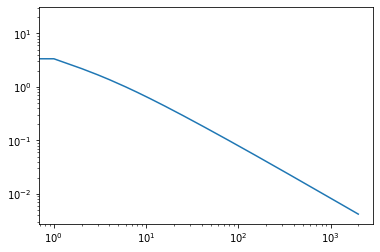

In [ ]:
x_valid = list()
y_valid = list()

for sample in valid_set:
  x_valid.append(sample[:-1])
  y_valid.append(sample[-1])

# train the model
params = logistic_regression(train_set)

# test the model 
print('validation loss 1: %1.3e \n' % loss(x_valid,y_valid,params))

In [ ]:
pred = predicted_results(x_valid,params)

In [ ]:
TP = 0
TN = 0
FP = 0
FN = 0

for i in range(len(y_valid)):

    if (y_valid[i] == 1) and (pred[i]== 1 ):
      TP += 1
    if (y_valid[i] == 0) and (pred[i] == 0):
      TN += 1
    if (y_valid[i] == 0) and (pred[i]== 1 ):
      FP += 1
    if (y_valid[i] == 1) and (pred[i] == 0):
      FN += 1

print("TP %d " % TP)
print("TN %d " % TN)
print("FP %d " % FP)
print("FN %d " % FN)

TP 45 
TN 83676 
FP 1612 
FN 110 


## Evaluate algorithm through cross-validation

**Cross validation:**

Cross-validation, sometimes called rotation estimation or out-of-sample testing, is any of various similar model validation techniques for assessing how the results of a statistical analysis will generalize to an independent data set. Cross-validation is a resampling method that uses different portions of the data to test and train a model on different iterations. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice.

**k-fold cross-validation:**

In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation. k = 10 is usually used.

Create functions for evaluating the algorithm:

In [48]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
  '''It returns the n_folds folds.
  
  @param: dataset It is the dataset to split.
  @param: n_folds The number of folds to create.
  '''

  # the returned value will be a list of lists (folds)
  dataset_split = list()

  # create a list from the dataset
  dataset_copy = dataset.tolist()

  # compute the number of elements in each fold
  fold_size = int(len(dataset) / n_folds)

  # build each fold by popping values from the copy of the dataset
  for _ in range(n_folds):
  	fold = list()
    # build the fold
  	while len(fold) < fold_size:
  		index = randrange(len(dataset_copy))
  		fold.append(dataset_copy.pop(index))
    # append the fold
  	dataset_split.append(fold)
   
  return dataset_split

In [49]:
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	"""
	It computes the accuracy between the two provided lists.
	Accuracy := n_correct / n_actual

	@param: actual It is the list with all the actual values.
	@param: predicted It is the list with all the predicted values.
	"""

	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	
	return correct / float(len(actual)) * 100.0

In [59]:
def compute_metrics(actual, predicted):
	"""
	It computes the metrics required.

	@param: actual It is the list with all the actual values.
	@param: predicted It is the list with all the predicted values.

	returns [acc,spec,sens,prec,f_meas,auc]
	"""

	[TP,TN,FP,FN]=collect_rates_single_prediction(actual,predicted)
	acc = accuracy(TP,TN,FP,FN)
	spec = specificity(TN,FP)
	sens = sensitivity(TP,FN)
	prec = precision(TP,FP)
	f_meas = F_measure(prec,sens)
	auc = AUC(sens, spec)
 
	return [acc,sens,spec,prec,f_meas,auc]

In [58]:
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
  '''It returns a list of accuracies, each of them computed on a certain fold.
  
  @param: dataset It is the dataset on which evaluating the algorithm.
  @param: algorithm It is the algorithm to evaluate; it is a lambda.
  @param: n_folds It represents the number of folds on which divide the dataset.
  @param: args It contains parameters of the algorithm (k in the case of KNN).
  '''

  # split the dataset into n_folds
  folds = cross_validation_split(dataset, n_folds)

  # this list contains the accuracy of the algorithm computed for each fold at a time
  scores = list()

  # for each fold compute the accuracy
  for fold in folds:
    training_set = list(folds) # copy the dataset
    training_set.remove(fold) # remove the current fold
    training_set = sum(training_set, []) # merge all the folds in training_set in one list
    test_set = list()

    # build the test_set by removing the class in each row of the current fold
    for row in fold:
      row_copy = list(row)
      test_set.append(row_copy)
      row_copy[-1] = None

    # compute the accuracy and append it to scores
    predicted = algorithm(training_set, test_set, *args)
    actual = [row[-1] for row in fold] # actual values are in the last column of the fold

    # compute the accuracy
    [acc,spec,sens,prec,f_meas,auc] = compute_metrics(actual, predicted)    
    scores.append([acc,spec,sens,prec,f_meas,auc])              

  return scores

Evaluate LR algorithm:

In [ ]:
n_folds = 3
rus_dataset = np.asarray(RUS(0.5, dataset.to_numpy()))

# I pass the result of the RUS function on the dataset
scores = evaluate_algorithm(rus_dataset, logistic_regression, n_folds)
print('Scores: %s\n' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

train_fraud len        :  0
train_not_fraud len    :  31
new train_not_fraud len:  0
new training set len   :  0




IndexError: ignored

Evaluate KNN algorithm:

In [69]:
n_folds = 3
rus_dataset = np.asarray(RUS(1/3, dataset.to_numpy()))

# I pass the result of the RUS function on the dataset
scores = evaluate_algorithm(rus_dataset,k_nearest_neighbors,n_folds,k)

acc=0
sens=0
spec=0
prec=0
fmeas=0
auc=0
for score in scores:
  acc += score[0]
  sens += score[1]
  spec += score[2]
  prec += score[3]
  fmeas += score[4]
  auc += score[5]


print('Mean Accuracy: %.3f%%' % (acc*100/float(len(scores))))
print('Mean sensitivity: %.3f%%' % (sens*100/float(len(scores))))
print('Mean specificity: %.3f%%' % (spec*100/float(len(scores))))
print('Mean precision: %.3f%%' % (prec*100/float(len(scores))))
print('Mean fmeas: %.3f%%' % (fmeas*100/float(len(scores))))
print('Mean auc: %.3f%%' % (auc*100/float(len(scores))))

train_fraud len        :  492
train_not_fraud len    :  284315
new train_not_fraud len:  1476
new training set len   :  1968


Mean Accuracy: 77.541%
Mean sensitivity: 24.421%
Mean specificity: 95.243%
Mean precision: 64.038%
Mean fmeas: 35.282%
Mean auc: 59.832%


Evaluate NB algorithm:

In [68]:
n_folds = 3
rus_dataset = np.asarray(RUS(1/3, dataset.to_numpy()))

# I pass the result of the RUS function on the dataset
scores = evaluate_algorithm(rus_dataset, naive_bayes, n_folds)

acc=0
sens=0
spec=0
prec=0
fmeas=0
auc=0
for score in scores:
  acc += score[0]
  sens += score[1]
  spec += score[2]
  prec += score[3]
  fmeas += score[4]
  auc += score[5]


print('Mean Accuracy: %.3f%%' % (acc*100/float(len(scores))))
print('Mean sensitivity: %.3f%%' % (sens*100/float(len(scores))))
print('Mean specificity: %.3f%%' % (spec*100/float(len(scores))))
print('Mean precision: %.3f%%' % (prec*100/float(len(scores))))
print('Mean fmeas: %.3f%%' % (fmeas*100/float(len(scores))))
print('Mean auc: %.3f%%' % (auc*100/float(len(scores))))

train_fraud len        :  492
train_not_fraud len    :  284315
new train_not_fraud len:  1476
new training set len   :  1968


Mean Accuracy: 94.817%
Mean sensitivity: 86.445%
Mean specificity: 97.636%
Mean precision: 92.336%
Mean fmeas: 89.251%
Mean auc: 92.040%


## Artificial Neural Network

### Setup

To initialize the parameters:

- Inizialize the biases with zero value.
- Inizialize the weights sampling from a Gaussian distribution with zero mean and with standard deviation 

In [ ]:
def initialize_params(layers_size):
  np.random.seed(0) # for reproducibility
  params = list()
  for i in range(len(layers_size) - 1):
    W = np.random.randn(layers_size[i+1], layers_size[i]) * np.sqrt(2 / (layers_size[i+1] + layers_size[i]))
    b = np.zeros((layers_size[i+1], 1))
    params.append(W)
    params.append(b)
  return params



In [ ]:
params = initialize_params([2, 5, 1])

In [52]:
dataset.shape


(284807, 31)